In [205]:
from sympy import *
import numpy as np
from IPython.display import display
from ipynb.fs.full.lab_01 import *
import numpy.random as rnd
import matplotlib.pyplot as plt
from matplotlib import cm

In [206]:
x1 = Symbol('x1')
x2 = Symbol('x2')
# f = simplify(x1 ** 2 + x2 ** 2 + 6 * x1 - 10*x2)


# f1 = simplify(x1**2 + x2**2 + 6 * x1 - 10 * x2 + x1**4)
f1 = simplify(100 * (x2 - x1)**2 + (1 - x1)**2)
f2 = simplify(100 * (x2 - x1 ** 2) ** 2 + (1 - x1) ** 2)
f3 = -simplify(2 * exp(-(x1 - 1) ** 2 / 4 - (x2 - 1) ** 2 / 1) + 3 * exp(-(x1 - 2) ** 2 / 9 - (x2 - 3) ** 2 / 4))
freeSyms = f1.free_symbols
eps = 1e-9
print('eps =', eps)
funcs = [f3]
funcs

eps = 1e-09


[-3*exp(-(x1 - 2)**2/9 - (x2 - 3)**2/4) - 2*exp(-(x1 - 1)**2/4 - (x2 - 1)**2)]

In [207]:
def hessian(func):
    fs = func.free_symbols
    return Matrix(derive_by_array(derive_by_array(func, fs), fs))

def gradient(func):
    return Matrix(derive_by_array(func, func.free_symbols))

def substitute(u, x):
    return Matrix(u.applyfunc(lambda k: k.evalf(subs=dict(zip(freeSyms, x)))))

def positive_definitive(m):
    eigenvalues = np.linalg.eigvals(m)
    if all(eigenvalues > 0):
        return m
    else:
        min_eig = min(eigenvalues)
        add = 2 * (-min_eig) * np.eye(m.shape[0])
        return m + add

In [208]:
def newton(f, x_start, eps):
    result = OptimizeResult("newton", 0, 0, 0, 0, [])
    h = hessian(f)
    grad = gradient(f)
    prevY = float('inf')
    curX = x_start
    curY = f.evalf(subs=dict(zip(freeSyms, curX)))

    result.data.append(curX)
    while abs(curY - prevY) > eps:
        prevY = curY
        curHes = substitute(h, curX)
        fixedCurHes = Matrix(positive_definitive(np.array(curHes, dtype=float)))
        curX = curX - fixedCurHes.inv() * substitute(grad, curX)
        curY = f.evalf(subs=dict(zip(freeSyms, curX)))
        result.iterations += 1
        result.data.append(curX)

    result.result = curX
    return result


In [209]:
def better_trajectory(plot_name, func, x1, y1, x2, y2, grad_data):
    npts = 100
    RGB = 25
    fig = plt.figure(figsize=(16,8))
    x, y = np.mgrid[x1:y1:100j,
                x2:y2:100j]
    z = func(x, y)
    fig.suptitle(plot_name, fontsize=26)
    # contour
    ax = fig.add_subplot(121)
    # display(z)
    plt.xlim(x1, y1)
    plt.ylim(x2, y2)
    plt.contourf(x, y, z, levels=20)
    plt.colorbar()
    plt.title('contour')

    #
    ax.plot([x[0] for x in grad_data], [x[1] for x in grad_data], color='r')

    # 3d view
    xa = np.arange(x1, y1, 0.01)
    ya = np.arange(x2, y2, 0.01)
    x, y = np.meshgrid(xa, ya)
    z = func(x, y)

    bx = fig.add_subplot(122, projection='3d')
    bx.plot_surface(x, y, z, cmap=cm.hot)

    plt.xlim(x1, y1)
    plt.ylim(x2, y2)
    plt.title('view')
    #
    plt.show()

Result of newton for {0} is Matrix([[1.26303502082816], [1.33439595557326]])
6
----------------------------------------------------------------------------------------------------
{x1, x2}


[Matrix([
 [0],
 [1]]),
 Matrix([
 [3.16369231000966],
 [1.61658179527836]]),
 Matrix([
 [0.818393656782328],
 [ 1.50548882279873]]),
 Matrix([
 [1.31361929736551],
 [1.23587542053338]]),
 Matrix([
 [1.25954470154664],
 [1.32697672419481]]),
 Matrix([
 [1.26299471494894],
 [1.33432452670443]]),
 Matrix([
 [1.26303502082816],
 [1.33439595557326]])]

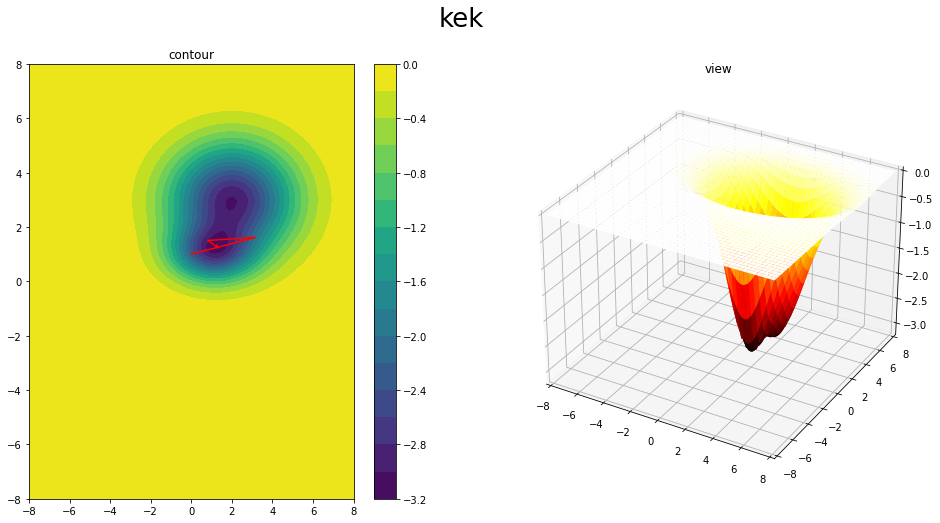

In [210]:
def apply(f, x, y):
    res = []
    for xi in x:
        for yi in y:
            res.append(f.evalf(subs=dict(zip(f.free_symbols, Matrix([xi, yi])))))
    return res
def fpr(a):
    print(a)
    return a

for curFunc in funcs:
    curX = Matrix([0, 1])
    eps = 1e-7
    result = newton(curFunc, curX, eps)
    print(str(result))
    display(result.data)
    print(result.iterations)
    print("-"*100)
    fi = lambda x, y: x**2 + y ** 2
    print(curFunc.free_symbols)
    better_trajectory('kek', lambdify(curFunc.free_symbols, curFunc, 'numpy'), -8, 8, -8, 8, result.data)
    # trajectory('kek', fi, -40, 40, -40, 40, result.data)
